In [3]:
import secretflow as sf
from secretflow.security.aggregation import SPUAggregator, SecureAggregator
from secretflow.ml.nn import FLModel
from secretflow.utils.simulation.datasets import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from secretflow.utils.simulation.data.ndarray import create_ndarray


# Check the version of your SecretFlow
print("The version of SecretFlow: {}".format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(["alice", "bob", "charlie"], address="local")
alice, bob, charlie = sf.PYU("alice"), sf.PYU("bob"), sf.PYU("charlie")
spu = sf.SPU(sf.utils.testing.cluster_def(["alice", "bob"]))

The version of SecretFlow: 1.5.0b0


/usr/local/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-09-04 02:34:45,322	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.81gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2024-09-04 02:34:46,478	INFO worker.py:1724 -- Started a local Ray instance.


In [4]:
df = pd.read_csv(dataset("creditcard"), sep=",")

In [5]:
seed = 1234
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df = df[~df.duplicated()]
df.drop("Time", axis=1, inplace=True)
df[df.duplicated()]["Class"].value_counts()

0    8063
Name: Class, dtype: int64

In [7]:
df = df[~df.duplicated()]
df.shape

(275663, 30)

In [8]:
df["Amount_bc"] = boxcox1p(df["Amount"], boxcox_normmax(df["Amount"] + 1))
df["Amount_log"] = np.log(1 + df["Amount"])
df.drop(["Amount", "Amount_log"], axis=1, inplace=True)

In [9]:
count_of_ones = (df["Class"] == 0).sum()

print(count_of_ones)
count_of_ones = (df["Class"] == 1).sum()

print(count_of_ones)

275190
473


In [10]:
df["Class"] = df["Class"].astype(float)
X = df.drop("Class", axis=1)
y = df.Class
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit_transform(X_scaled);

In [11]:
cum_sum = np.cumsum(pca.explained_variance_ratio_) * 100
comp = [n for n in range(len(cum_sum))]

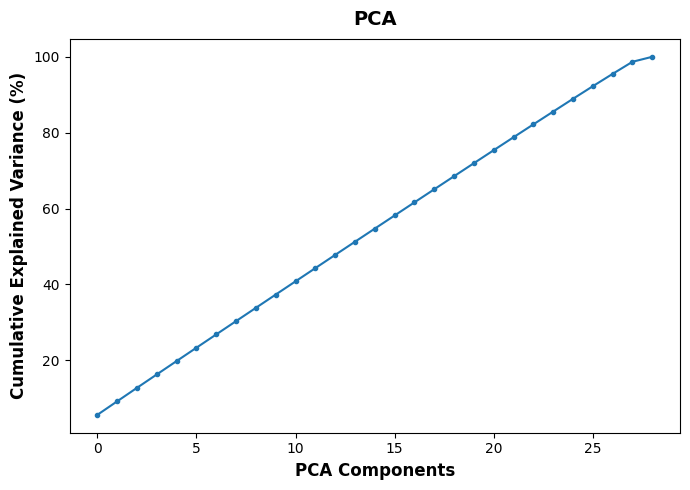

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(comp, cum_sum, marker=".")
plt.xlabel("PCA Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("PCA")
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=seed
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed
)
print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Training set: 176424
Validation set: 44106
Test set: 55133


In [14]:
# from secretflow.security.aggregation import SecureAggregator
# from secretflow.ml.nn import FLModel
# import tensorflow as tf
# from tensorflow import keras
# EPOCHS = 100
# BATCH_SIZE = 256
# def objective(input_shape,num_classes,name='model'):
#     def objective(trial):

#         model = keras.Sequential()

#         in_feat = X_train.shape[0]

#         for i in range(trial.suggest_int("n_layers", 1, 2)):
#             out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
#             model.add(keras.layers.Dense(units=out_feat, activation='relu'))
#             model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
#             in_feat=out_feat
 
#         model.add(keras.layers.Dense(1, activation='sigmoid'))
    
#         model.compile(loss='binary_crossentropy',
#                     optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
#                     metrics=['accuracy'])
    
#         early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
#         model.fit(X_train, y_train,
#                 validation_data = (X_val, y_val),
#                 shuffle = True,
#                 batch_size = BATCH_SIZE,
#                 epochs = EPOCHS,
#                 callbacks = [early_stop], 
#                 verbose = False )
    
#         score = model.evaluate(X_val, y_val, verbose=0)
                  
#         return score[1]
#     return objective

In [15]:
# import optuna
# num_classes=10
# input_shape=(28,28,1)
# study = optuna.create_study(direction="maximize")
# study.optimize(objective(input_shape,num_classes), n_trials=10)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# params_1 = []

# for key, value in trial.params.items():
#     params_1.append(value)
#     print("    {}: {}".format(key, value))

In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_train.shape, X_test.shape, X_val.shape

((176424, 29, 1), (55133, 29, 1), (44106, 29, 1))

In [17]:
parts = {
    alice: 0.5,
    bob: 0.5,
}
if not isinstance(y_train, np.ndarray):
    y_train = y_train.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()
if not isinstance(y_val, np.ndarray):
    y_val = y_val.to_numpy()
fed_train_x = create_ndarray(X_train, parts=parts, axis=0)
fed_train_y = create_ndarray(y_train, parts=parts, axis=0)
fed_val_x = create_ndarray(X_val, parts=parts, axis=0)
fed_val_y = create_ndarray(y_val, parts=parts, axis=0)
fed_test_x = create_ndarray(X_test, parts=parts, axis=0)
fed_test_y = create_ndarray(y_test, parts=parts, axis=0)
print(fed_train_x.partition_shape())
print(fed_train_y.partition_shape())
print(fed_val_x.partition_shape())
print(fed_val_y.partition_shape())
print(fed_test_x.partition_shape())
print(fed_test_y.partition_shape())
fed_train_x

{PYURuntime(alice): (88212, 29, 1), PYURuntime(bob): (88212, 29, 1)}
{PYURuntime(alice): (88212,), PYURuntime(bob): (88212,)}
{PYURuntime(alice): (22053, 29, 1), PYURuntime(bob): (22053, 29, 1)}
{PYURuntime(alice): (22053,), PYURuntime(bob): (22053,)}
{PYURuntime(alice): (27566, 29, 1), PYURuntime(bob): (27566, 29, 1)}
{PYURuntime(alice): (27566,), PYURuntime(bob): (27566,)}


FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x74d2acb79ea0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x74d2acce7850>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>)

In [18]:
def create_model(input_shape, num_classes, name="model"):
    def create_model():
        from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
        from tensorflow.keras.layers import Conv1D, MaxPool1D
        from tensorflow.keras import Sequential
        from tensorflow.keras.optimizers import Adam
        
        model = Sequential()
        model.add(Conv1D(32, 2, activation="relu", input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))

        model.add(Conv1D(64, 2, activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Flatten())
        model.add(Dense(64, activation="relu"))
        model.add(Dropout(0.5))

        model.add(Dense(1, activation="sigmoid"))

        model.compile(
            optimizer=Adam(lr=0.0001), loss="binary_crossentropy", metrics=["accuracy"]
        )
        model.summary()

        return model

    return create_model

In [32]:
# dont delete
# device_list = [alice, bob]
# secure_aggregator = SecureAggregator(charlie, [alice, bob])
# spu_aggregator = SPUAggregator(spu)
# num_classes = 10
# input_shape = X_train[0].shape
# model = create_model(input_shape, num_classes)
# fed_model = FLModel(
#     server=charlie,
#     device_list=device_list,
#     model=model,
#     aggregator=secure_aggregator,
#     strategy="fed_avg_w",
#     backend="tensorflow",
# )

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [20]:
import numpy as np
from secretflow.device import PYU, SPU

# 初始化参与方设备
alice = PYU('alice')
bob = PYU('bob')
charlie = PYU('charlie')

# 假设有一个全局的数据集
X_train = np.random.rand(1000, 32, 32, 3)  # 示例数据，1000张32x32的RGB图像

# 将数据分发给各个客户端，确保每个客户端的数据形状相同
X_train_alice = X_train[:500]  # 前500张图片分给Alice
X_train_bob = X_train[500:]    # 后500张图片分给Bob

# 随机掩码聚合器的定义
class RandomMaskAggregator:
    def __init__(self, server, clients):
        self.server = server
        self.clients = clients
        self.masks = {}

    def mask_data(self, client_data):
        # 确保每个客户端的数据形状相同
        data_shapes = [data.shape for data in client_data]
        if len(set(data_shapes)) != 1:
            raise ValueError("All client data must have the same shape for aggregation.")
        
        masks = [np.random.rand(*data.shape) for data in client_data]
        self.masks = {client: mask for client, mask in zip(self.clients, masks)}
        masked_data = [data + mask for data, mask in zip(client_data, masks)]
        return masked_data

    def aggregate(self, masked_data):
        # 直接对所有掩码后的数据进行相加
        sum_masked_data = np.sum(masked_data, axis=0)
        # 然后减去所有的掩码
        total_mask = np.sum(list(self.masks.values()), axis=0)
        return sum_masked_data - total_mask




In [35]:
clients = [alice, bob]
aggregator = RandomMaskAggregator(server=charlie, clients=clients)
masked_data = aggregator.mask_data([X_train_alice, X_train_bob])
aggregated_data = aggregator.aggregate(masked_data)
num_classes = 10
input_shape = X_train[0].shape
model = create_model(input_shape, num_classes)
# 创建FL模型
fed_model = FLModel(
    server=charlie,
    device_list=clients,
    model=model,
    aggregator=aggregator,
    strategy="fed_avg_w",
    backend="tensorflow",
)


INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.ml.nn.fl.backend.tensorflow.strategy.fed_avg_w.PYUFedAvgW'> with party bob.


In [22]:
X_train.dtype

dtype('float64')

In [23]:
y_train.dtype

dtype('float64')

In [24]:
X_val.dtype

dtype('float64')

In [25]:
y_val.dtype

dtype('float64')

In [36]:
EPOCHS = 5
BATCH_SIZE = 256
history = fed_model.fit(
    fed_train_x,
    fed_train_y,
    validation_data=(fed_val_x, fed_val_y),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    aggregate_freq=1,
    verbose=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x74d2acb79ea0>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x74d2acce7850>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x74d2acbc8730>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x74d2acbc9e10>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 256, 'batch_sampling_rate': None, 'epochs': 5, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x74d2acbc9c30>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x74d2acbc9600>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x74d2

AttributeError: 'RandomMaskAggregator' object has no attribute 'average'

In [ ]:
global_eval, local_eval = fed_model.evaluate(fed_test_x, fed_test_y)
for e in global_eval:
    print(e.name, e.result())

In [ ]:
# Draw accuracy values for training & validation
plt.plot(history["global_history"]['accuracy'])
plt.plot(history["global_history"]['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history["global_history"]['loss'])
plt.plot(history["global_history"]['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [ ]:
y_pred =fed_model.predict(fed_test_x,batch_size=256)
print(y_pred)
argmax = []
y_pred.reveal()
for val in y_pred:
    if val >= 0.5:
      argmax.append(1)
    else:
        argmax.append(0)
argmax[:10]